# Off-axis PSF cubes for debris disk imaging SPC

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Populating the interactive namespace from numpy and matplotlib


## Load packages

In [2]:
import numpy as np
import os
#os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/STScI/WFIRST/webbpsf-data')
import webbpsf
from webbpsf import wfirst
import ipywidgets
from astropy.io import fits

WebbPSF produces various log messages while it works, using Python's built-in logging mechanism. In order to see them, we need to set up a log handler that will display them on the screen. This is done using the ``setup_logging`` function. 

In [3]:
webbpsf.setup_logging('ERROR') # Reduced verbosity

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


## off-axis PSF lookup subroutine

In [4]:
def xy_to_psf(x, y, quad_cube):
    hw = quad_cube.shape[-1] // 2
    if x >= hw and y >= hw: # in first quadrant
        s = (y - hw)*hw + (x - hw)
        return quad_cube[s]
    elif x < hw and y >= hw: # second quadrant
        s = (y - hw)*hw + (hw - x - 1)
        return quad_cube[s,:,::-1]
    elif x < hw and y < hw: # third quadrant
        s = (hw - y - 1)*hw + (hw - x - 1)
        return quad_cube[s,::-1,::-1]
    else:                 # fourth quadrant
        s = (hw - y - 1)*hw + (x - hw)
        return quad_cube[s,::-1,:]

## Get parameters from debris disk imaging SPC model at 661 nm

In [5]:
fov = 3.4 # arcsec
cgi_mode = 'DISKSPC_F661'
#cgi_mode = 'DISKSPC_F72
#cgi_mode = 'DISKSPC_F883'

diskspc = wfirst.CGI(mode=cgi_mode)
diskspc.options['source_offset_r'] = 0 # arcsec
diskspc.options['source_offset_theta'] = 0 # deg w.r.t. North

filter_fname = diskspc._filters[diskspc.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)

print('{:.1f}% bandpass centered at {:.1f} nm'.format(
100*float(filter_hdulist[1].header.get('DELTALAM'))/float(filter_hdulist[1].header.get('LAMBDA0')),
float(filter_hdulist[1].header.get('LAMBDA0'))/10))

lamoD_asec_F661 = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*diskspc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D): %.5f arcsec" % lamoD_asec_F661)

10.0% bandpass centered at 661.0 nm
System diffraction resolution element scale (lambda_0/D): 0.05681 arcsec


### Set pixelscale to 56.81 mas =  0.25*lambda/D at 661 nm, and FoV to 3.4 arcsec

In [23]:
#cgi_mode = 'DISKSPC_F661'
cgi_mode = 'DISKSPC_F721'
#cgi_mode = 'DISKSPC_F883'

diskspc = wfirst.CGI(mode=cgi_mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)

In [24]:
psf_onax = diskspc.calc_psf(display=False, fov_arcsec=fov)

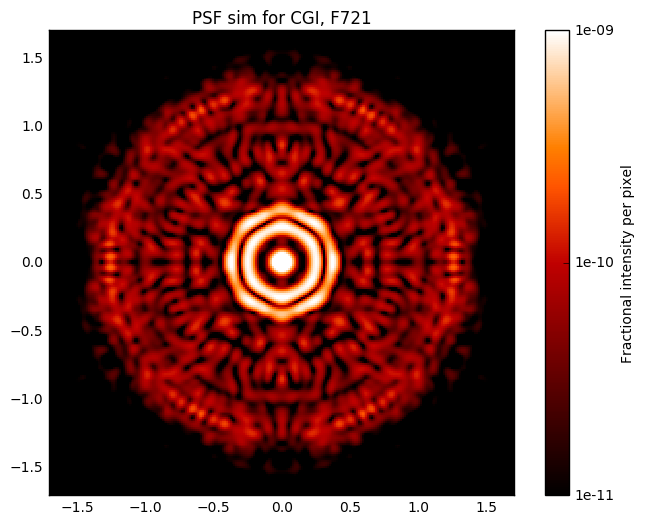

In [25]:
plt.figure(figsize=(8,6))
webbpsf.display_psf(psf_onax, ext=0, vmin=1e-11, vmax=1e-9)

## Define the off-axis PSF cube

In [26]:
M_fp2 = psf_onax[0].shape[0]//2
dxi = diskspc.pixelscale/diskspc.optsys.oversample
print('oversampled image array half width {:d} points'.format(M_fp2))
print('spatial sampling {:.6} arcsec'.format(dxi))

oversampled image array half width 120 points
spatial sampling 0.0142022 arcsec


### define PSF sample coordinates (xi, eta) and cube over first quadrant

In [27]:
xis = np.matrix(np.linspace(-M_fp2+0.5, M_fp2-0.5, 2*M_fp2)*dxi)
offax_Xis = np.array(xis[0,M_fp2:].T)
offax_XisEtas = list(zip(list(np.ravel(np.ones_like(offax_Xis)*offax_Xis.T)),
                         list(np.ravel(offax_Xis*np.ones_like(offax_Xis.T)))))

In [28]:
len(offax_XisEtas)

14400

In [29]:
offax_psf_map = np.zeros((len(offax_XisEtas), 2*M_fp2, 2*M_fp2), dtype=np.float32)
print(offax_psf_map.shape)

(14400, 240, 240)


## Loop over position indices in first quadrant and compute PSF

In [30]:
for ii, (delta_xi, delta_eta) in enumerate(offax_XisEtas):
    diskspc.options['source_offset_r'] = np.sqrt(delta_xi**2 + delta_eta**2) # arcsec
    diskspc.options['source_offset_theta'] = np.rad2deg(np.arctan2(delta_eta, delta_xi)) - 90. # deg w.r.t. North
    psf_offax = diskspc.calc_psf(display=False, fov_arcsec=fov)
    offax_psf_map[ii,:,:] = psf_offax[0].data

In [31]:
offax_psf_map_fname = 'offax_psf_map_{:s}.fits.gz'.format(diskspc.mode)
print(offax_psf_map_fname)

offax_psf_map_DISKSPC_F721.fits.gz


In [32]:
offax_psf_map_hdu = fits.PrimaryHDU(offax_psf_map.astype(np.float32))
offax_psf_map_hdu.writeto(offax_psf_map_fname, clobber=True)

In [33]:
%ls -lh

total 5.7G
-rw-r--r--. 1 mrizzo lhea 105K Jan 31 14:57 debrisSPC_offax_psf_cube-Copy1.ipynb
-rw-r--r--. 1 mrizzo lhea 112K Jan 31 22:07 debrisSPC_offax_psf_cube.ipynb
-rw-r--r--. 1 mrizzo lhea 2.9G Jan 31 22:09 offax_psf_map_DISKSPC_F721.fits.gz
-rw-r--r--. 1 mrizzo lhea 2.9G Jan 30 23:44 offax_psf_map_DISKSPC_F883.fits.gz
-rw-r--r--. 1 mrizzo lhea   72 Jan 31 14:55 Untitled.ipynb
-rw-r--r--. 1 mrizzo lhea 794K Jan 30 19:01 wfirst_cgi_demo.ipynb


## Test PSF lookup subroutine for arbitrary image pixel indices

In [37]:
x_test = 70
y_test = 70
test_psf = xy_to_psf(x_test, y_test, offax_psf_map)

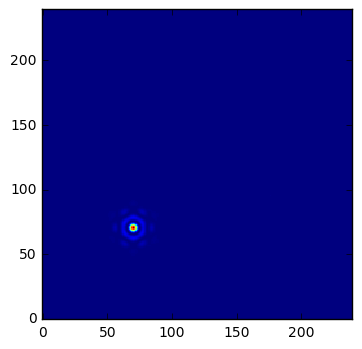

In [38]:
plt.imshow(test_psf)

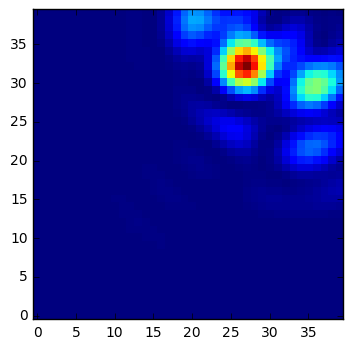

In [36]:
plt.imshow(test_psf[y_test-20:y_test+20, x_test-20:x_test+20])